In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [74]:
from libra import ObservationArchive, mask_simultaneous_transits, transit_model, trappist1

In [75]:

def model(params, planet, times):
    original_params = trappist1(planet)
    amp, depth, t0, c0, c1 = params
    original_params.rp = depth**0.5
    original_params.t0 = t0
    
    t = times - times.mean()
    
    fluxes = (amp * transit_model(times, original_params) + 
              c0 * t +  c1 * t**2)
    
    return fluxes

def chi2(params, planet, times, observed_fluxes, obs_err):
    model_fluxes = model(params, planet, times)
    return np.sum( (observed_fluxes - model_fluxes)**2 / obs_err**2)

In [76]:
from scipy.optimize import fmin_l_bfgs_b

In [77]:
# import h5py
# f = h5py.File('/Users/bmmorris/git/libra/libra/data/outputs/trappist1_bright.hdf5')

# dict(f['h']['2018-11-09T12:58:39.195'].attrs)

In [78]:
from libra import nirspec_pixel_wavelengths

wavelengths = nirspec_pixel_wavelengths()

n_bins = 5
bin_width = len(wavelengths) // n_bins
bin_width
bin_centers = np.array([wavelengths[i*bin_width:(i+1)*bin_width].mean().value 
                        for i in range(n_bins)])

In [79]:
bin_centers

array([ 0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ])

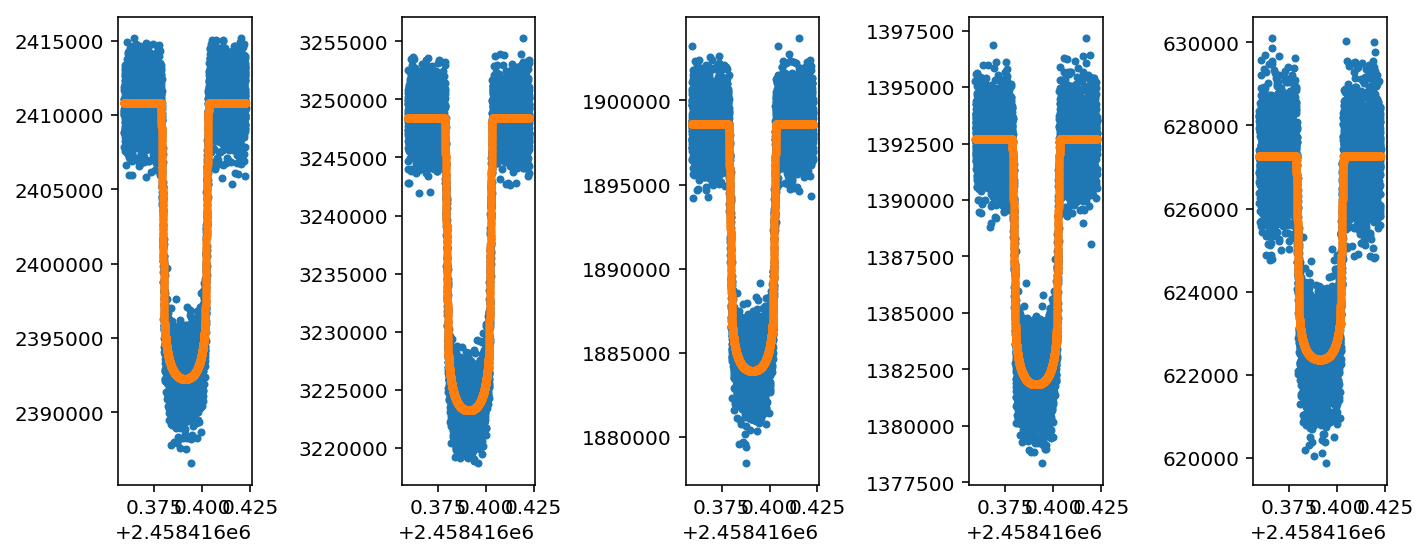

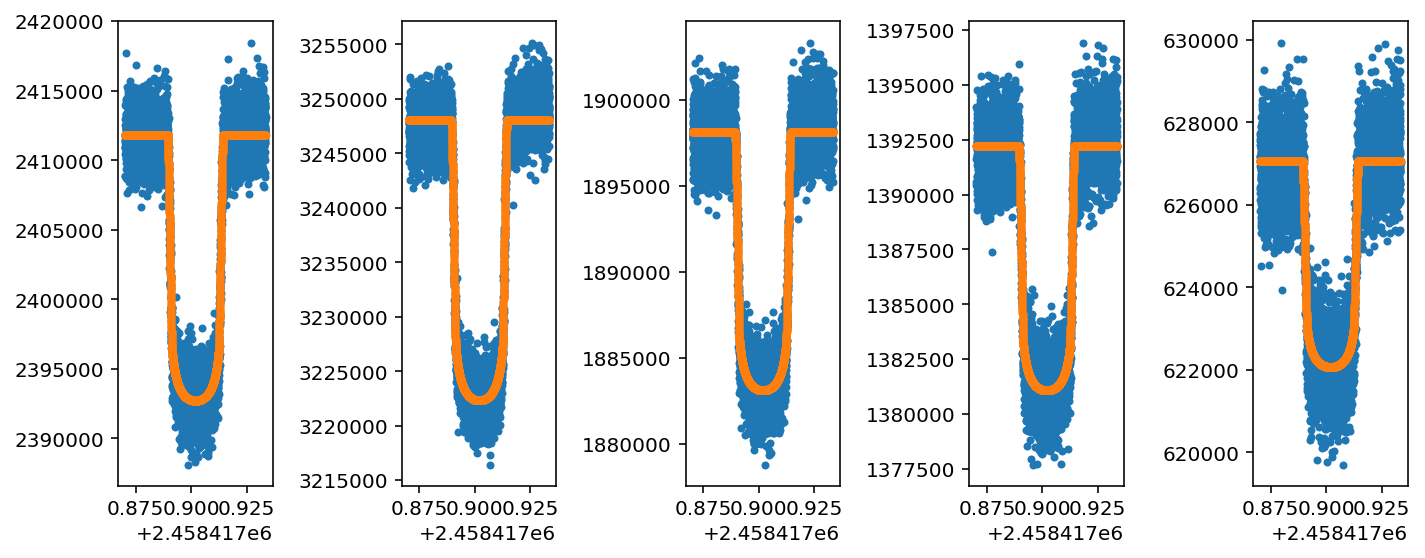

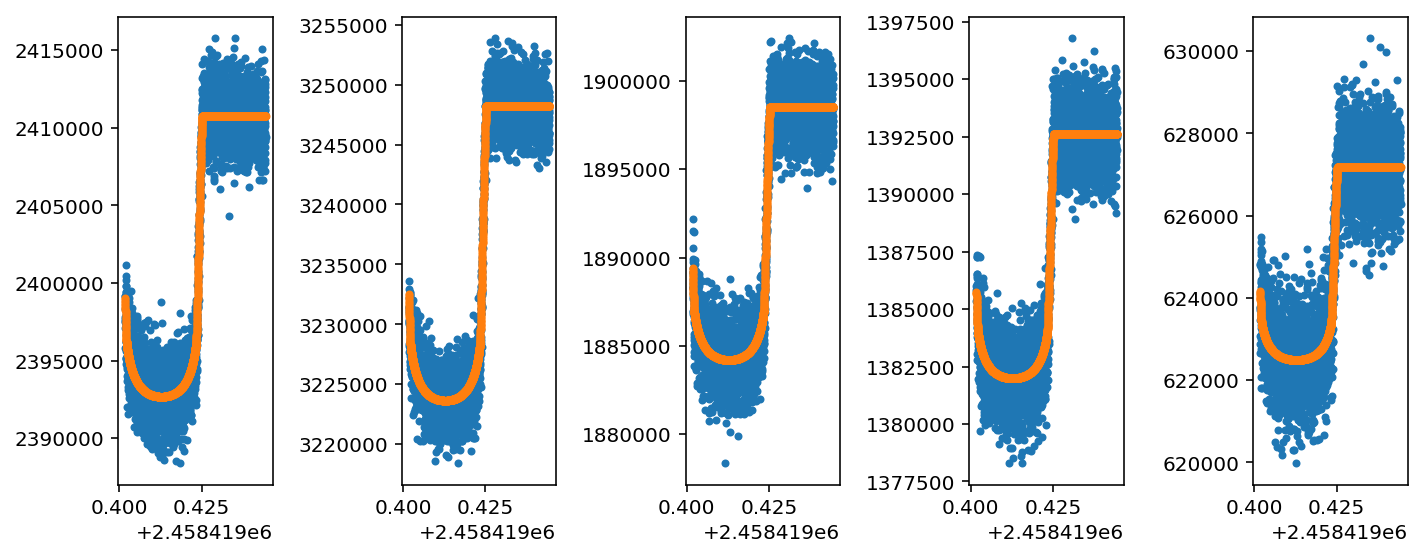

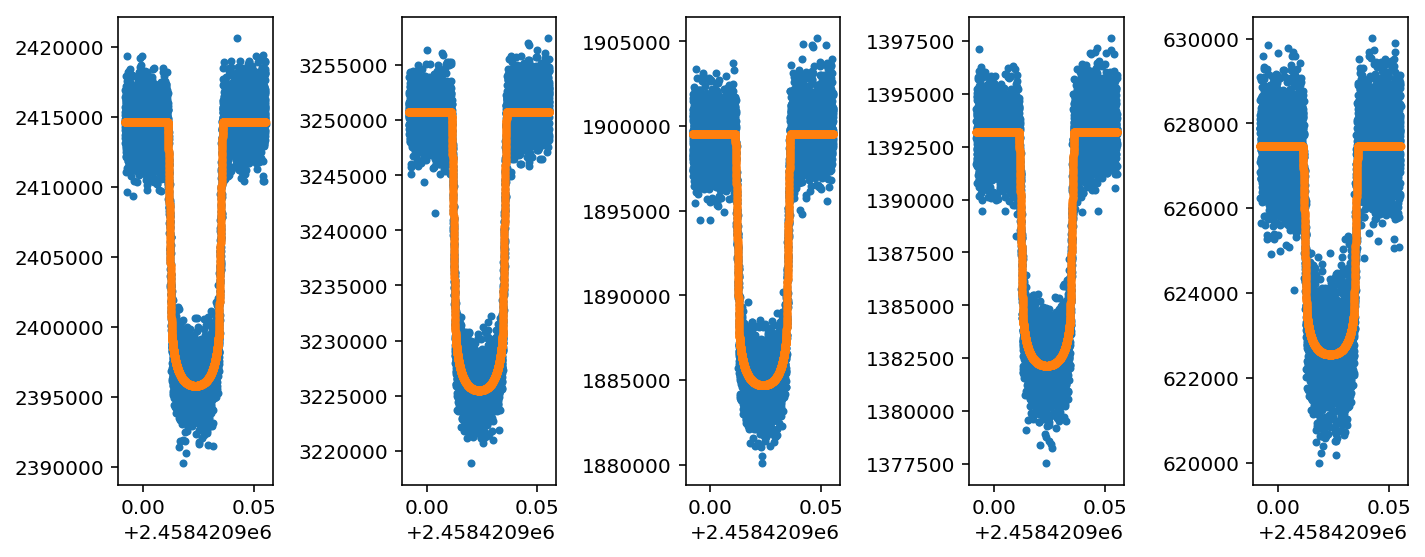

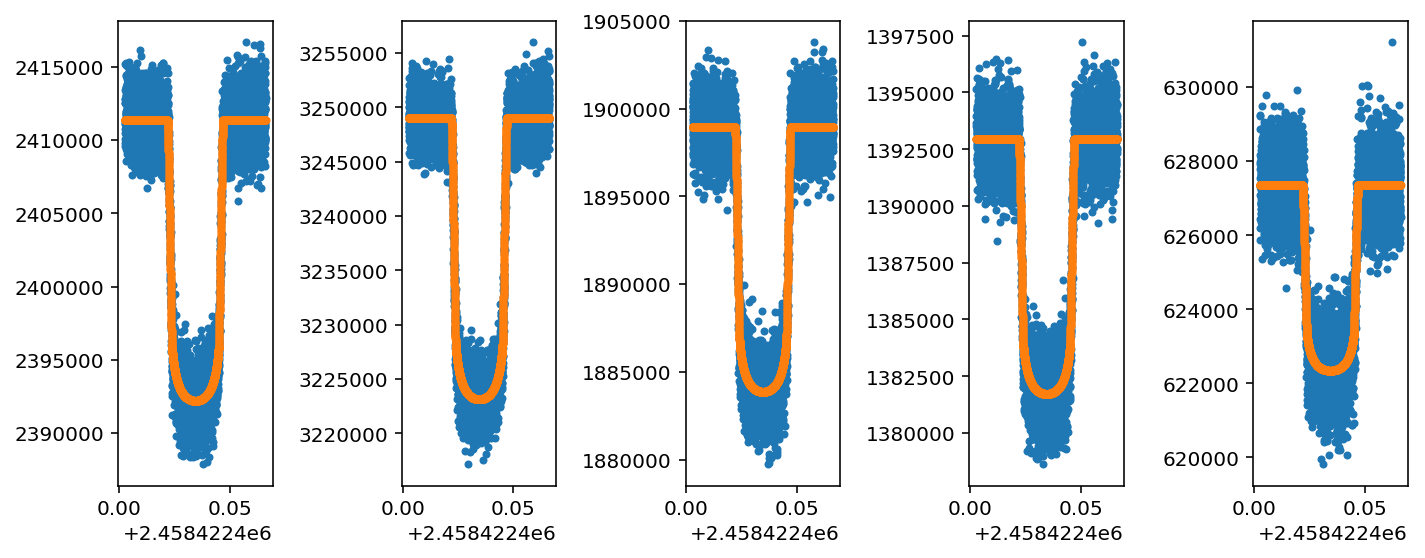

In [80]:
run_name = 'trappist1_transmission'

bin_results = []

with ObservationArchive(run_name, 'r') as obs:
    planet = 'b'
    for obs_planet in getattr(obs, planet):
        results = []
        fig, ax = plt.subplots(1, n_bins, figsize=(10, 4))
        for i in range(n_bins):
            mask = mask_simultaneous_transits(obs_planet.times, planet)
            obs_time = obs_planet.times[mask]
            obs_flux = np.sum(obs_planet.spectra[mask, i*bin_width:(i+1)*bin_width], axis=1)
            obs_err = np.sqrt(obs_flux)

            params = trappist1(planet)
            initp = [np.median(obs_flux), params.rp**2, params.t0, 0.00001, 0.00001]
            bounds = [[np.min(obs_flux), np.max(obs_flux)], 
                      [0.9 * params.rp**2, 1.5 * params.rp**2],
                      [params.t0 - 0.01, params.t0 + 0.01], 
                      [-10, 10], [-10, 10]]

            result = fmin_l_bfgs_b(chi2, initp, args=(planet, obs_time, obs_flux, obs_err), 
                                   approx_grad=True, bounds=bounds)[0]
            results.append(result)
            
            ax[i].plot(obs_time, obs_flux, '.')

            ax[i].plot(obs_time, model(result, planet, obs_time), '.')
        bin_results.append(results)
        fig.tight_layout()
        mid_transit_answer = obs_planet.attrs['t0']
        plt.show()

In [81]:
depths = np.array([j[1] for i in bin_results for j in i]).reshape(-1, n_bins)

depths

array([[ 0.00699227,  0.00704186,  0.00702043,  0.00708149,  0.00707361],
       [ 0.00718066,  0.00720182,  0.00719238,  0.00727482,  0.00723051],
       [ 0.0068143 ,  0.00687941,  0.00684776,  0.00692399,  0.00677951],
       [ 0.0070902 ,  0.00707399,  0.00709572,  0.00719703,  0.00710522],
       [ 0.00721271,  0.0072252 ,  0.00722815,  0.0073197 ,  0.00724246]])

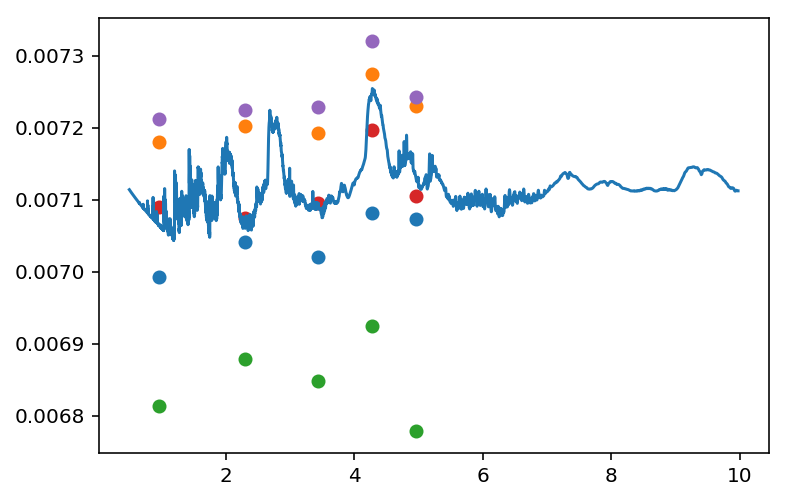

In [82]:
swl, sf = np.loadtxt('../libra/data/transmission/t1b_10bar_venus_clear.txt', unpack=True)

u = trappist1('b').u
ld_factor = 1 - u[0]/3 - u[1]/6

plt.plot(swl, sf * ld_factor, label='with LD')

for i in range(n_bins):
    plt.scatter(bin_centers, depths[i, :])

In [17]:
from celerite.modeling import Model
from copy import deepcopy

original_params = trappist1('h')

# Define the model
# class MeanModel(Model):
#     parameter_names = ['amp', 'depth', 't0', 'c0', 'c1']

#     def get_value(self, t):
#         original_params.rp = self.depth**0.5
#         original_params.t0 = self.t0
#         times = t - t.mean()
#         return (self.amp * transit_model(t, original_params) + 
#                 self.c0 * times +  self.c1 * times**2)

class MeanModel(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(original_params)
        params.rp = self.depth**0.5
        params.t0 = self.t0
        times = t - t.mean()
        return self.amp * transit_model(t, params)

In [18]:
# import celerite
# from celerite import terms
# from scipy.optimize import minimize

# initp_dict = dict(depth=original_params.rp**2, t0=original_params.t0)

# parameter_bounds = dict(depth=[0.5 * original_params.rp**2, 1.5 * original_params.rp**2],
#                         t0=[original_params.t0 - 0.5, original_params.t0 + 0.5])

# mean_model = MeanModel(**initp_dict, bounds=parameter_bounds)

# x = obs_time
# y = obs_flux
# yerr = obs_err/2

# # Set up the GP model
# # kernel = terms.Matern32Term(log_sigma=np.log(obs_err.mean()), log_rho=2,
# #                             bounds=dict(log_sigma=(-100, 0), log_rho=(np.log(0.1), np.log(5))))

# kernel = terms.Matern32Term(log_sigma=np.log(obs_err.mean()), log_rho=np.log(0.01),
#                             bounds=dict(log_sigma=(None, 10), log_rho=(None, np.log(0.01))))

# # kernel = terms.RealTerm(log_a=-5, log_c=-5)# + 

# # kernel = terms.RealTerm(log_a=-5, log_c=-5)
# gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
# gp.compute(x, yerr)
# print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# # Define a cost function
# def neg_log_like(params, y, gp):
#     gp.set_parameter_vector(params)
#     return -gp.log_likelihood(y)

# def grad_neg_log_like(params, y, gp):
#     gp.set_parameter_vector(params)
#     return -gp.grad_log_likelihood(y)[1]

# # Fit for the maximum likelihood parameters
# initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()
# soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
#                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
# gp.set_parameter_vector(soln.x)
# print("Final log-likelihood: {0}".format(-soln.fun))

# # Make the maximum likelihood prediction
# t = np.linspace(obs_time.min(), obs_time.max(), 500)
# mu, var = gp.predict(y, t, return_var=True)
# std = np.sqrt(var)

# plt.plot(obs_time, obs_flux, '.', zorder=-100, alpha=0.5)
# plt.plot(t, mu)
# plt.fill_between(t, mu-std, mu+std, alpha=1, zorder=-100)

Initial log-likelihood: -118696.62301838543
Final log-likelihood: -113843.08496309722
[  1.27790213e+01   6.00463246e+00   9.57717525e+06   3.33679060e-03
   2.45766255e+06]


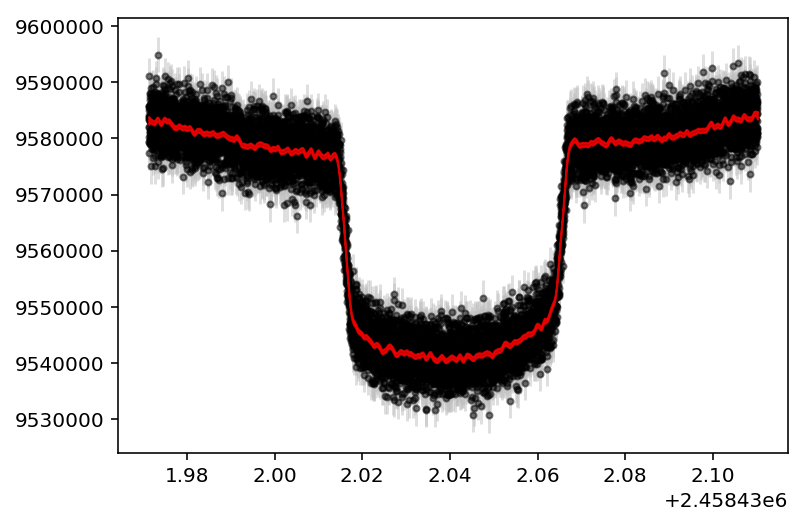

In [19]:
%matplotlib inline
import celerite
from celerite import terms
from scipy.optimize import minimize

initp_dict = dict(amp=np.median(obs_flux), depth=original_params.rp**2, 
                  t0=original_params.t0)#, c0=0, c1=0)

parameter_bounds = dict(amp=[np.min(obs_flux)*0.9, np.max(obs_flux)*1.1], 
                        depth=[0.5 * original_params.rp**2, 1.5 * original_params.rp**2],
                        t0=[original_params.t0 - 0.5, original_params.t0 + 0.5])#,
                        #c0=[None, None], c1=[None, None])
mean_model = MeanModel(**initp_dict, bounds=parameter_bounds)

x = obs_time
y = obs_flux #/ transit_model(obs_time, original_params)
yerr = obs_err #* 2


# kernel = terms.Matern32Term(log_sigma=8, log_rho=-9,
#                             bounds=dict(log_sigma=(None, None), log_rho=(np.log(5*1/60/60/24), None)))

Q = 1.0 / np.sqrt(2.0)
log_omega0 = np.log(2*np.pi/(0.5/24))#5 #3.0

S0 = 5 #np.log(np.median(obs_err)*2) #10
log_cadence_min = None #np.log(2*np.pi/(2./24))
log_cadence_max = np.log(2*np.pi/(0.25/24))

bounds = dict(log_S0=(-15, 30), log_Q=(-15, 15),
              log_omega0=(log_cadence_min, log_cadence_max))

kernel = terms.SHOTerm(log_S0=0, log_Q=np.log(Q), log_omega0=log_omega0,
                        bounds=bounds)

kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term


# kernel += terms.Matern32Term(log_sigma=8, log_rho=-9,
#                              bounds=dict(log_sigma=(None, None), log_rho=(np.log(5*1/60/60/24), None)))


# kernel += terms.SHOTerm(log_S0=1, log_Q=1, log_omega0=np.log(2*np.pi/10),
#                        bounds=dict(log_S0=(None, None), 
#                                    log_Q=(None, None), 
#                                    log_omega0=(np.log(5*1/60/60/24), None)))
# Set up the GP model
# kernel = terms.Matern32Term(log_sigma=np.log(obs_err.mean()), log_rho=np.log(0.01),
#                             bounds=dict(log_sigma=(None, None), log_rho=(None, None)))


gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(obs_time.min(), obs_time.max(), 5000)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

print(soln.x)
plt.errorbar(x, y, yerr, fmt='.', color='k', alpha=0.5, ecolor='silver')
# plt.plot(obs_time, obs_flux, '.', zorder=-100, alpha=0.5)
plt.plot(t, mu, 'r')
plt.fill_between(t, mu-std, mu+std, alpha=0.8, zorder=100, color='r')
plt.show()

In [20]:
import emcee

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

initial = np.array(soln.x)
ndim, nwalkers = len(initial), len(initial) * 2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                threads=8)

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 4000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


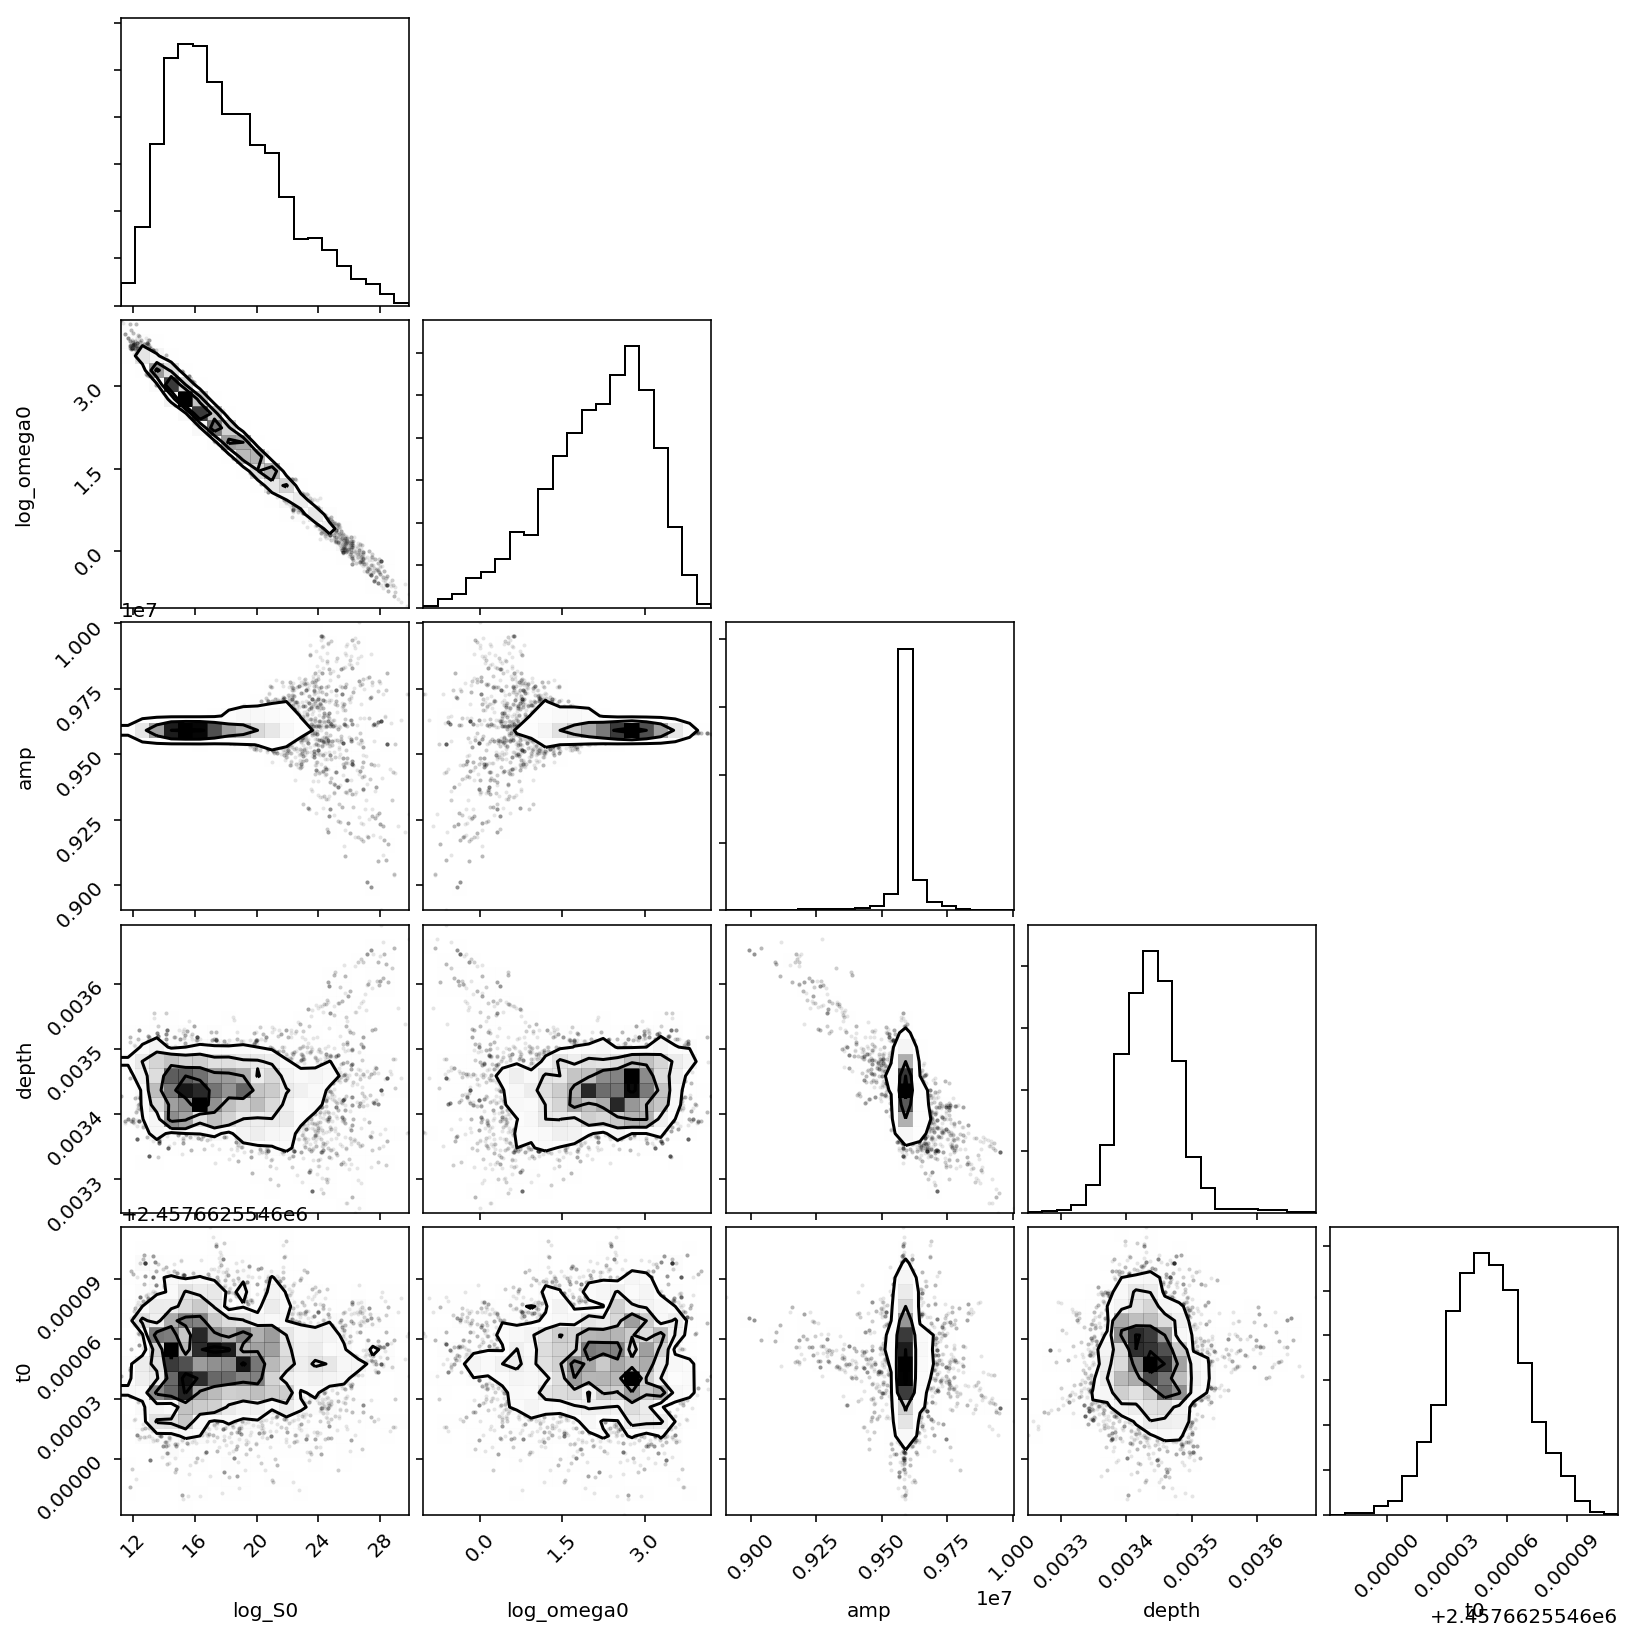

In [21]:
from corner import corner

# corner(sampler.flatchain, labels=['log_S0', 'log_Q', 'log_omega0', 'amp', 'depth', 't0'])

corner(sampler.flatchain, labels=['log_S0', 'log_omega0', 'amp', 'depth', 't0'])


# corner(sampler.flatchain, labels=['log_sigma', 'log_rho', 'amp', 'depth', 't0'])
# corner(sampler.flatchain, labels=['log_S0', 'log_Q', 'log_omega0', 'log_sigma', 'log_rho', 'amp', 'depth', 't0'])
# corner(sampler.flatchain, labels=['log_sigma', 'log_rho', 'amp', 'depth', 't0', 'c0', 'c1'])
plt.show()

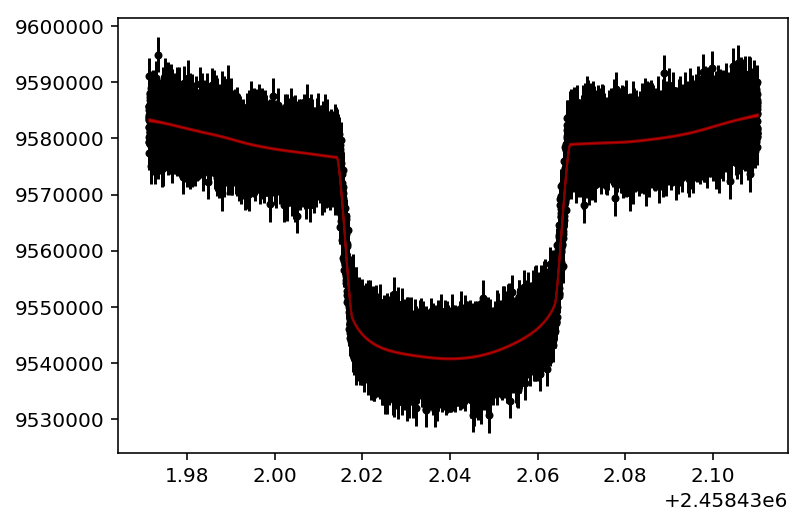

In [22]:
%matplotlib inline
plt.errorbar(x, y, yerr=yerr, fmt=".k", zorder=-100)

bestp = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]
gp.set_parameter_vector(bestp)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)
plt.fill_between(t, mu-std, mu+std, color='r', alpha=0.5)
plt.show()

(9530692.86350099, 9594848.7639268488)

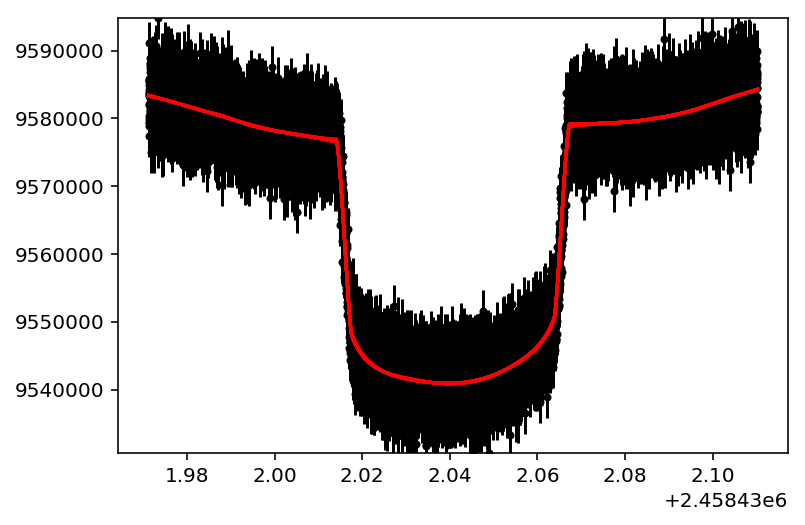

In [26]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", zorder=-100)

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color='r', alpha=0.5, zorder=100)
plt.ylim([y.min(), y.max()])

In [27]:
n_transits = np.round((samples_t0.mean() - mid_transit_answer) / trappist1('h').per)

mid_transit_answer_translated = mid_transit_answer + trappist1('h').per * n_transits

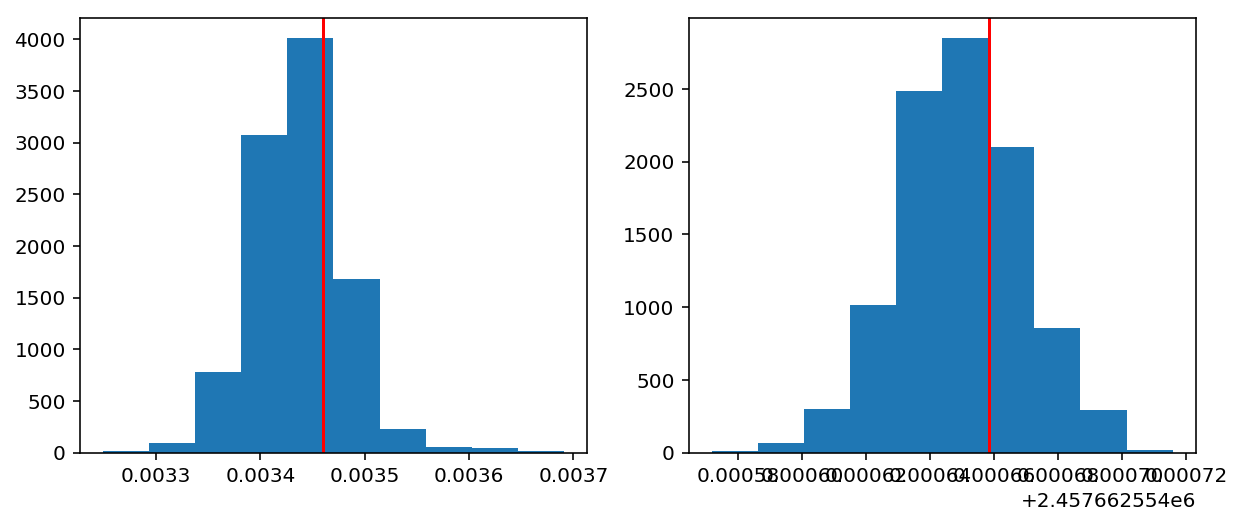

In [28]:
samples_depth = samples[:, -2]
samples_t0 = samples[:, -1]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(samples_depth)
ax[0].axvline(trappist1('h').rp**2, color='r')


ax[1].hist(samples_t0)
ax[1].axvline(mid_transit_answer_translated, color='r')

plt.show()